In [19]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

NUM_SAMPLES = 1000
MU_MAX = 0.20 # 1/h
K_S = 1       # g/l
Y_XS = 0.5    # g/g
Y_PX = 0.2    # g/g
S_F = 10      # g/l

T_START = 0
T_END = 100
TIME_RANGE = int(T_END - T_START) # Absolute time

# Initial conditions
X_0 = 0.05
S_0 = 10.0
V_0 = 1.0
F_0 = 1
IC = [0.05, 0.0, 10.0, 1.0]  # [X0, P0, S0, V0]

dt = 1                       # Time step
L = int(TIME_RANGE / dt)      # Simulation steps
N_p = 5                       # Prediction horizon
Q = 1.0                       # Weight for tracking
R = 0.1                       # Weight for control effort

# Bounds for feeding rate
F_MIN = 0.0                  # l/h
F_MAX = 2.0                  # l/h
BOUNDS = [(F_MIN, F_MAX) for _ in range(N_p)] 

# Dynamic model
def dynamic_system(t, y, F):
    X, S, V = y
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt, dV_dt])

# Discretized model
def discretized_model(t, X, S, V, F, h=0.1):
    k1 = dynamic_system(t, [X, S, V], F)
    k2 = dynamic_system(t + h / 2, [X + k1[0] * h / 2, S + k1[1] * h / 2, V + k1[2] * h / 2], F)
    k3 = dynamic_system(t + h / 2, [X + k2[0] * h / 2, S + k2[1] * h / 2, V + k2[2] * h / 2], F)
    k4 = dynamic_system(t + h, [X + k3[0] * h, S + k3[1] * h, V + k3[2] * h], F)

    X_next = X + (h / 6) * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0])
    S_next = S + (h / 6) * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1])
    V_next = V + (h / 6) * (k1[2] + 2 * k2[2] + 2 * k3[2] + k4[2])
    return X_next, S_next, V_next

# Setpoint function
def set_point(t):
    if t <= 20:
        return 1.5
    elif 21 <= t < 40:
        return 3
    else:
        return 5

# Cost Function
def cost_function(F_opt, X, S, V, t):
    J = 0
    X_curr, S_curr, V_curr = X, S, V
    for k in range(N_p):
        X_sp = set_point(t + k * dt)
        X_next, S_next, V_next = discretized_model(t, X_curr, S_curr, V_curr, F_opt[k])
        J += Q * (X_sp - X_next) ** 2
        if k > 0:
            J += R * (F_opt[k] - F_opt[k - 1]) ** 2
        X_curr, S_curr, V_curr = X_next, S_next, V_next
    return J

In [20]:
def main():
    # Initialize system variables
    X = np.ones(L+1)
    S = np.ones(L+1)
    V = np.ones(L+1)
    F = np.ones(L)
    X[0], S[0], V[0] = X_0, S_0, V_0
    
    # MPC Loop
    for step in tqdm(range(L)):
        t=step*dt
        res = minimize(cost_function, F_0 * np.ones(N_p), args=(X[step], S[step], V[step], t), bounds=BOUNDS, method="SLSQP")
        F[step] = res.x[0]
        sol = solve_ivp(dynamic_system, t_span=(t, t + dt), y0=[X[step], S[step], V[step]], args=(F[step],))
        X[step + 1], S[step + 1], V[step + 1] = sol.y[:, -1]

    return X, S, V, F

In [21]:
X, S, V, F = main()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 104.95it/s]


In [22]:
outputs = pd.DataFrame({'X': X, 'S': S, 'V': V})
inputs = pd.DataFrame({'F': F})

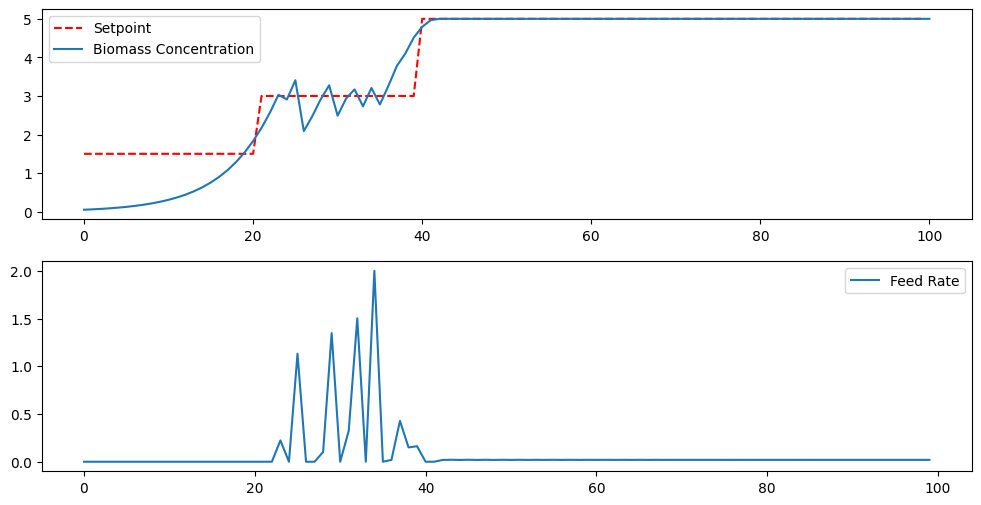

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot([set_point(t) for t in range(0, TIME_RANGE)], "r--", label="Setpoint")
plt.plot(np.arange(0, TIME_RANGE+dt, dt), X, label='Biomass Concentration')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, TIME_RANGE, dt), F, label='Feed Rate')
plt.legend()
plt.show()

### Evaluation

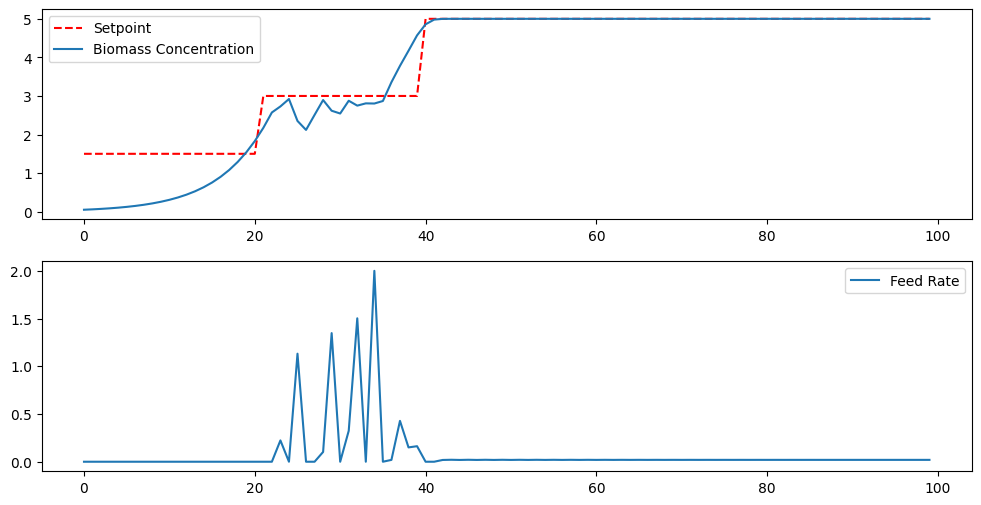

In [24]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d

t_points = np.arange(0, TIME_RANGE, dt)
F_func = interp1d(t_points, F, kind="linear", fill_value="extrapolate")

def plant_model(t, y):
    X, S, V = y
    F = F_func(t)
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

t_span = [0, TIME_RANGE]
y0 = [X_0, S_0, V_0]
times = np.arange(0, TIME_RANGE, dt)
sol_t = [0]
sol_X = [X_0]
sol_S = [S_0]
sol_V = [V_0]

for i in range(len(times)-1):
    sol = solve_ivp(plant_model, [times[i], times[i+1]], y0, method='RK45')
    y0 = sol.y[:, -1] # Update initial condition
    sol_t.append(times[i+1])
    sol_X.append(y0[0])
    sol_S.append(y0[1])
    sol_V.append(y0[2])
    
sol_t = np.array(sol_t)
sol_X = np.array(sol_X)
sol_S = np.array(sol_S)
sol_V = np.array(sol_V)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot([set_point(t) for t in range(0, TIME_RANGE)], "r--", label="Setpoint")
plt.plot(sol_t, sol_X, label='Biomass Concentration')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sol_t, F_func(sol_t), label='Feed Rate')
plt.legend()

plt.show()